In [7]:
from tqdm import tqdm
import numpy as np
import pandas as pd
import torch
import random
random.seed(2024)
from typing import List, Union, Dict, Tuple
from tqdm.autonotebook import trange
from optimum.onnxruntime import ORTModelForFeatureExtraction
from transformers import AutoTokenizer
from datasets import load_dataset

In [2]:
def _text_length(text: Union[List[int], List[List[int]]]):
    if isinstance(text, dict):  # {key: value} case
        return len(next(iter(text.values())))
    elif not hasattr(text, "__len__"):  # Object has no len() method
        return 1
    elif len(text) == 0 or isinstance(text[0], int):  # Empty string or list of ints
        return len(text)
    else:
        return sum([len(t) for t in text])  # Sum of length of individual strings
    
def inference(tokenizer: AutoTokenizer, model: ORTModelForFeatureExtraction, 
             sentences: List[str], batch_size:int = 16, verbose: bool =False):
    
    length_sorted_idx = np.argsort([-_text_length(sen) for sen in sentences])
    sentences_sorted = [sentences[idx] for idx in length_sorted_idx]

    embeddings = []

    with tqdm(total=len(sentences), desc="Batches", disable = not verbose) as pbar:
        for i in trange(0, len(sentences), batch_size, desc="Batches", disable = True):
            batch = sentences_sorted[i:i+batch_size]
            encoded_inputs = tokenizer(batch, padding=True, truncation=True, max_length=128, return_tensors='pt').to(torch.device('cpu'))
            with torch.no_grad():
                output = model(**encoded_inputs)['last_hidden_state'].detach()
                batch_prototypes = torch.mean(output, dim=1)
                batch_prototypes = torch.nn.functional.normalize(batch_prototypes, p=2, dim=1).to(torch.device('cpu'))
                embeddings.extend(batch_prototypes)
            pbar.update(len(batch))

    embeddings = [embeddings[idx] for idx in np.argsort(length_sorted_idx)]
    embeddings = np.asarray([emb.numpy() for emb in embeddings])

    return embeddings

In [3]:
category_dataset = "clw8998/Shopee-Categories"
p_name_dataset = 'clw8998/Coupang-Product-Set-1M'
model_id = 'clw8998/Product-Classification-Model-Distilled'
batch_size = 16
model = ORTModelForFeatureExtraction.from_pretrained(model_id, export=False)
tokenizer = AutoTokenizer.from_pretrained(model_id)

categories = load_dataset(category_dataset, split="train")['category']
p_names = load_dataset(p_name_dataset, split="train")['product_name']

# replace your Start, End here
p_names = p_names[714275: 742845]
#p_names = random.sample(p_names, 10)

In [4]:
print(f"Num of category: {len(categories)}, Num of p_name: {len(p_names)}")

Num of category: 1425, Num of p_name: 28570


In [5]:
def get_category(tokenizer: AutoTokenizer, model: ORTModelForFeatureExtraction, 
                 p_names: List[str], categories: List[str], top_k: int = 3) -> Dict[str, List[Tuple[str, float]]]:

    p_names_embeddings = inference(tokenizer, model, p_names, batch_size, verbose=True)  # (n, 768)
    categories_embeddings = inference(tokenizer, model, categories, batch_size, verbose=True)  # (m, 768)
    scores_matrix = np.dot(p_names_embeddings, categories_embeddings.T)  # (n, m)
    
    result = {}
    for i in range(len(p_names)):
        top_k_indices = np.argsort(-scores_matrix[i])[:top_k]
        top_k_with_scores = [(categories[index], scores_matrix[i][index]) for index in top_k_indices]
        result[p_names[i]] = top_k_with_scores

    return result


In [8]:
top_k = 3
result = get_category(tokenizer, model, p_names, categories, top_k=top_k)

Batches: 100%|██████████| 1425/1425 [00:00<00:00, 2313.54it/s]


In [9]:
df = pd.DataFrame.from_dict(result, orient='index')
df_expanded = pd.DataFrame(
    df.apply(lambda x: pd.Series([item for sublist in x for item in sublist]), axis=1)
)

columns = []
for i in range(top_k):
    columns.append(f'category_{i+1}')
    columns.append(f'score_{i+1}')

df_expanded.columns = columns
df_expanded = df_expanded.reset_index().rename(columns={'index': 'p_name'})
df_expanded[['class_1', 'class_2', 'class_3']] = df_expanded['category_1'].apply(lambda x: pd.Series(x.split('_'))[:3])
cols = df_expanded.columns.tolist()
new_order = ['p_name', 'class_1', 'class_2', 'class_3', 'category_1'] + cols[2:]

df_expanded = df_expanded[new_order]
df_expanded = df_expanded.loc[:, ~df_expanded.columns.duplicated()]

df_expanded.to_csv('M11202222_categories.csv', index=False, encoding='utf-8-sig')
df_expanded

,p_name,class_1,class_2,class_3,category_1,score_1,category_2,score_2,category_3,score_3
0,"BASIC HOUSE 素色純棉重磅短袖T恤 LVTS0103 3入組, 白色+灰色+黑色",女生衣著,大尺碼,T恤,女生衣著_大尺碼_T恤,0.750299,女生衣著_T恤,0.748085,女生衣著_上衣類_其他上衣,0.682336
1,"Y PLUS+ 迷你削鉛筆器 Kontsu X09-1, 混色, 32件",文創商品,文具,鉛筆盒,文創商品_文具_鉛筆盒,0.697876,居家生活_文具_鉛筆盒,0.670191,文創商品_文具_文具用品、修正用品,0.537313
2,"Healthy Food 關節護理乳香萃取錠 600mg, 2罐, 60顆",美妝保健,保健食品、營養品,順暢保養食品,美妝保健_保健食品、營養品_順暢保養食品,0.720668,美妝保健_保健食品、營養品_機能性食品,0.697723,美妝保健_保健食品、營養品_其他,0.680872
3,"Dyvipro 女式防水緊身褲防曬衣 WLW-08, 黑色",女生衣著,休閒運動服飾,長褲,女生衣著_休閒運動服飾_長褲,0.693810,女生衣著_休閒運動服飾_其他長褲,0.692762,女生衣著_短褲_連身褲 / 吊帶褲,0.626098
4,"牛奶蛋白強化洗髮精 花卉&庭園, 1000ml, 2個",美妝保健,美髮護理,洗髮精,美妝保健_美髮護理_洗髮精,0.928188,美妝保健_美髮護理_潤髮乳,0.624283,居家生活_日用品_洗衣精、衣物清潔劑,0.586510
...,...,...,...,...,...,...,...,...,...,...
28565,"市場敏感的優質葡萄酒禮盒, 黑單, 2個",家電影音,大型家電,紅酒櫃,家電影音_大型家電_紅酒櫃,0.591619,居家生活_節慶、派對用品_其他,0.568644,居家生活_節慶、派對用品_裝扮道具,0.505857
28566,"女式黑色 101 Radimos 露肩短袖長連衣裙 CH-2316098, 紅色",女生衣著,大尺碼,裙裝,女生衣著_大尺碼_裙裝,0.933176,女生衣著_裙子_裙裝,0.889788,女生衣著_大尺碼_套裝,0.697706
28567,"MomNest 推車把手罩 Lian Solo專用, 黑色網紋款, 1份",居家生活,五金修繕,手推車,居家生活_五金修繕_手推車,0.671121,汽機車零件百貨_機車百貨_機車車罩,0.587334,嬰幼童與母親_外出用品_手推車配件,0.566394
28568,"MILAN 學齡前的第一把剪刀 小動物系列, 小兔子, 5支",居家生活,餐廚,刀具、料理用剪刀,居家生活_餐廚_刀具、料理用剪刀,0.624589,娛樂、收藏_電影動漫周邊_文具、美術用具,0.434419,居家生活_五金修繕_鉗子,0.433096


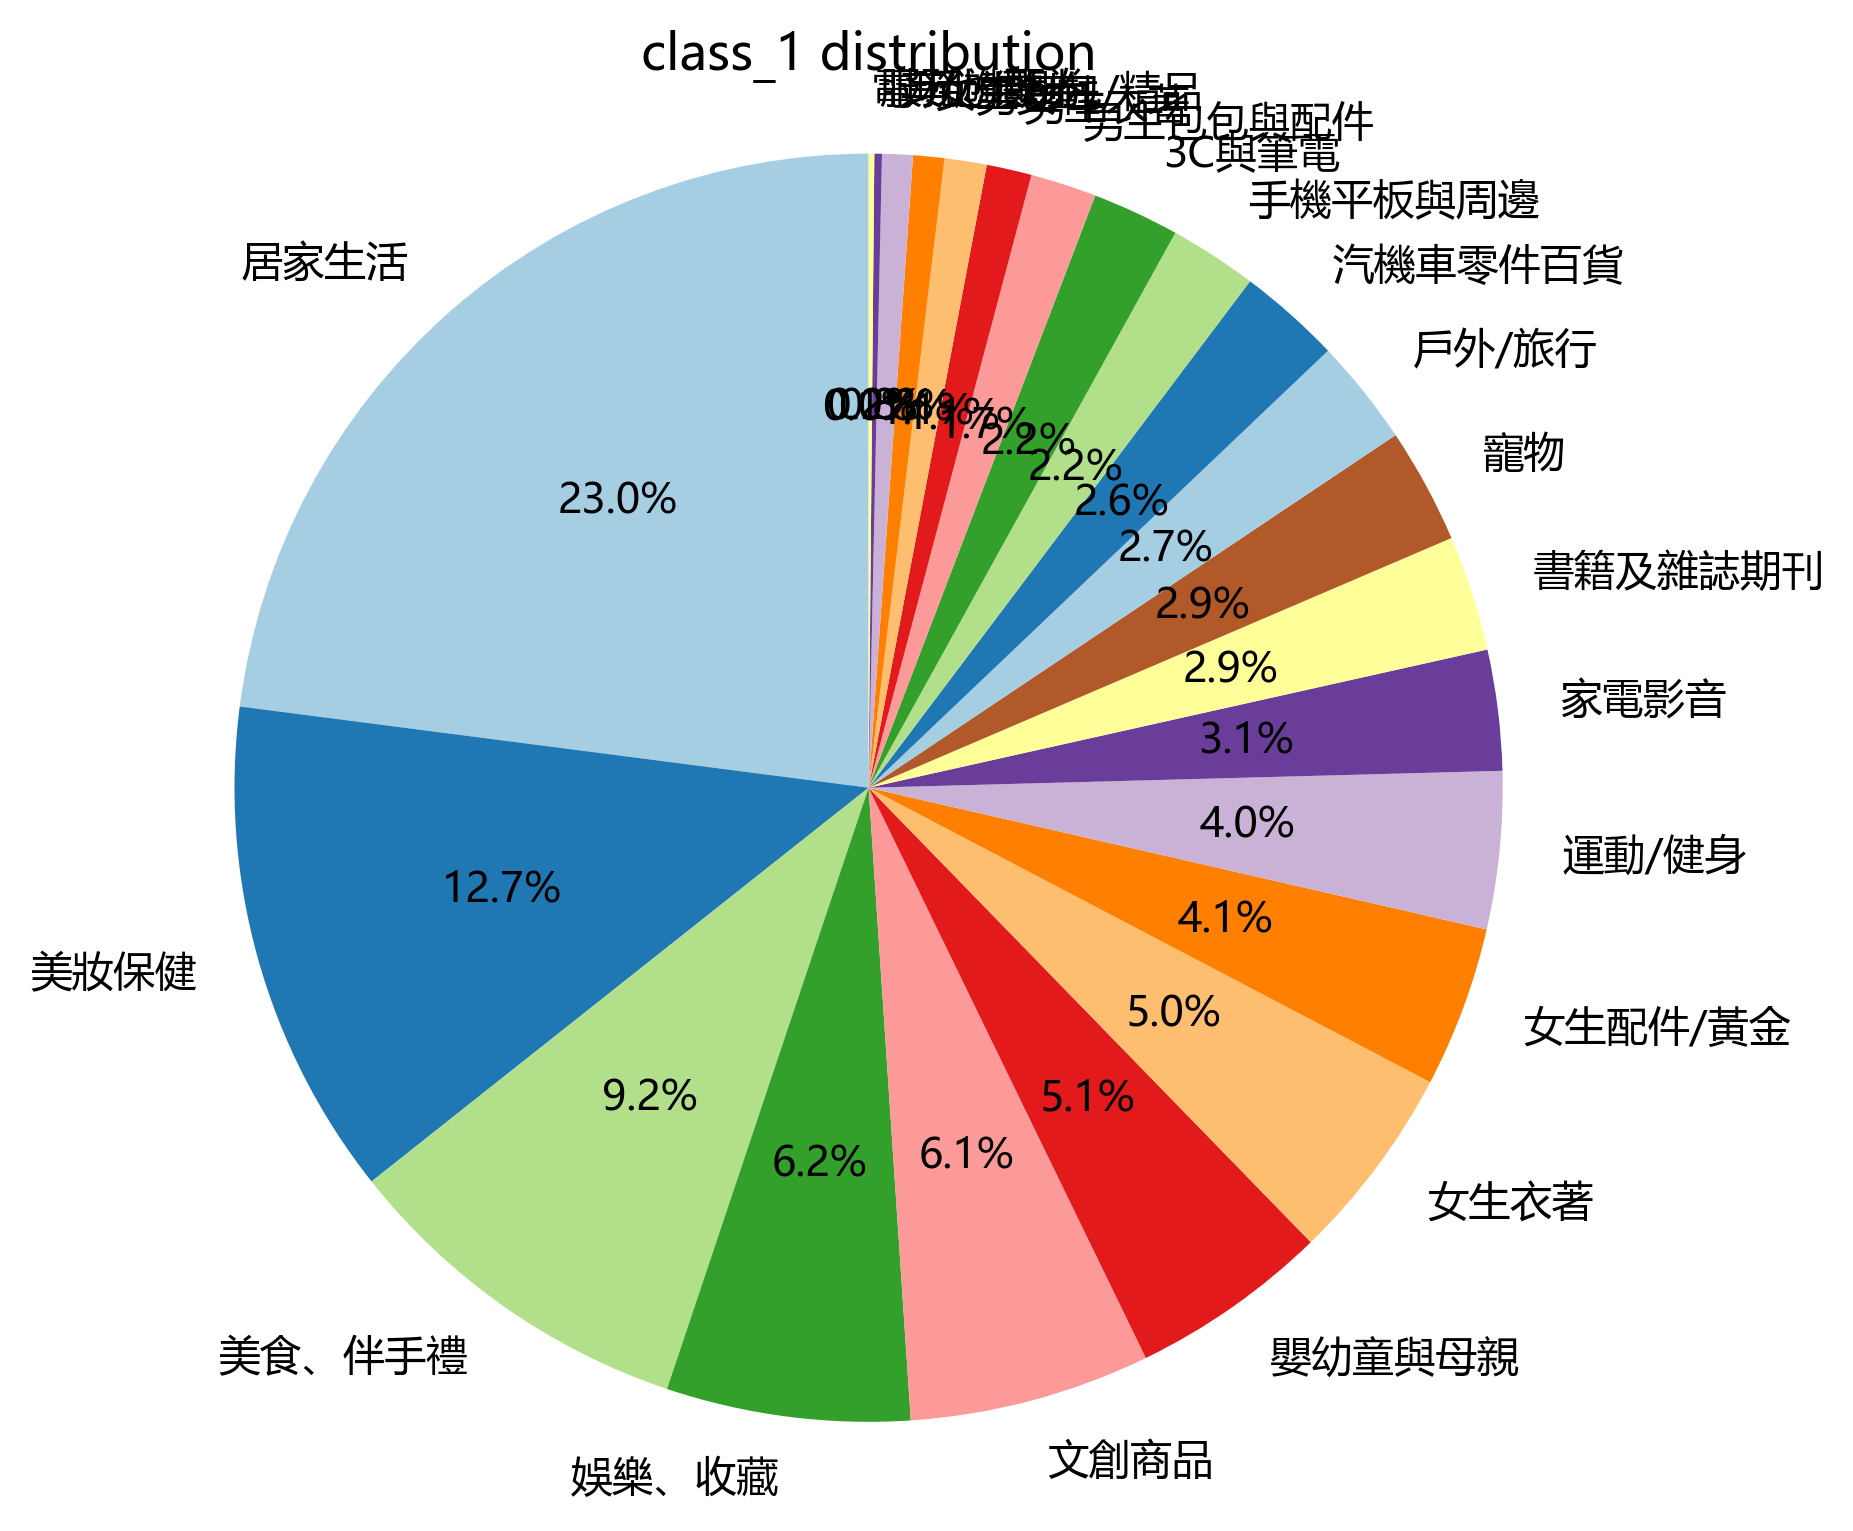

In [10]:
import matplotlib.pyplot as plt

plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']
plt.rcParams['axes.unicode_minus'] = False

class_1_distribution = df_expanded['class_1'].value_counts()

plt.figure(figsize=(6, 6), dpi=300)
plt.pie(class_1_distribution, labels=class_1_distribution.index, autopct='%1.1f%%', startangle=90, colors=plt.cm.Paired.colors)
plt.title('class_1 distribution')
plt.axis('equal')
plt.savefig('M11202222_distribution.png', dpi=300) 
plt.show()

列出前20項的分類(因為圓餅圖上太擠了所以弄成txt檔)


In [12]:
top_20_class_1_distribution = class_1_distribution.head(20)

with open("top_20_categories.txt", "w", encoding="utf-8") as f:
    f.write("Top 20 Categories by Product Count:\n")
    for idx, (category, count) in enumerate(top_20_class_1_distribution.items(), 1):
        f.write(f"{idx}. {category}: {count}\n")

print("finish")

finish


列出未被分類到的種類
並畫出長條圖比較有被分類的數量和沒被分類的數量

finish


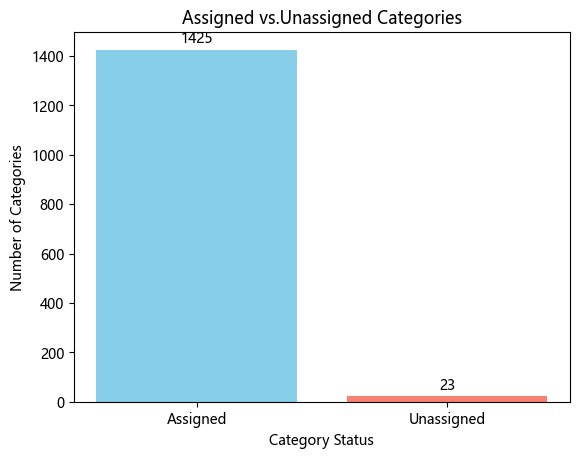

In [14]:
all_categories = set(categories)
assigned_categories = set(df_expanded['category_1'].unique())

unassigned_categories = all_categories - assigned_categories
unassigned_categories_count = len(unassigned_categories)

with open("unassigned_categories.txt", "w", encoding="utf-8") as f:
    f.write(f"Total Unassigned Categories: {unassigned_categories_count}\n")
    f.write(f"List of Unassigned Categories:\n")
    for category in sorted(unassigned_categories):
        f.write(f"- {category}\n")

print("finish")

assigned_count = len(assigned_categories)
unassigned_count = unassigned_categories_count
plt.figure()
bars = plt.bar(["Assigned", "Unassigned"], [assigned_count, unassigned_count], color=['skyblue', 'salmon'])
for bar in bars:
    y = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, y + 10, int(y), ha='center', va='bottom', fontsize=10)
plt.title("Assigned vs. Unassigned Categories")
plt.xlabel("Category Status")
plt.ylabel("Number of Categories")
plt.savefig("Assigned_vs_Unassigned_Categories.png", dpi=300)
plt.show()

測試用（不用理這個block）

In [18]:
type(categories)
#categories

list

商品分類導覽(把大中小層的數量都列出來)


In [19]:
category_hierarchy = {}
df_for_hierarchy = df_expanded[['p_name', 'class_1', 'class_2', 'class_3']]

for _, row in df_for_hierarchy.iterrows():
    product_name = row["p_name"]
    top_level = row["class_1"]
    mid_level = row["class_2"]
    sub_level = row["class_3"]   
    
    # 建立大類
    if top_level not in category_hierarchy:
        category_hierarchy[top_level] = {"count": 0, "subcategories": {}}
    category_hierarchy[top_level]["count"] += 1  # 更新大類的商品數量

    # 如果有中類
    if mid_level:
        if mid_level not in category_hierarchy[top_level]["subcategories"]:
            category_hierarchy[top_level]["subcategories"][mid_level] = {"count": 0, "subcategories": {}}
        category_hierarchy[top_level]["subcategories"][mid_level]["count"] += 1  # 更新中類的商品數量

        # 如果有小類
        if sub_level:
            if sub_level not in category_hierarchy[top_level]["subcategories"][mid_level]["subcategories"]:
                category_hierarchy[top_level]["subcategories"][mid_level]["subcategories"][sub_level] = {"count": 0}
            category_hierarchy[top_level]["subcategories"][mid_level]["subcategories"][sub_level]["count"] += 1  # 更新小類的商品數量

# 儲存分類導覽至 txt 檔案
def save_navigation_to_txt(category_hierarchy, filename="category_hierarchy_counts.txt"):
    with open(filename, "w", encoding="utf-8") as f:
        for top_level, mid_levels in category_hierarchy.items():
            f.write(f"{top_level}: {mid_levels['count']} items\n")
           
            for mid_level, sub_levels in mid_levels["subcategories"].items():
                f.write(f"  {mid_level}: {sub_levels['count']} items\n")
               
                for sub_level, details in sub_levels["subcategories"].items():
                    f.write(f"    {sub_level}: {details['count']} items\n")

# 執行儲存
save_navigation_to_txt(category_hierarchy)
print("分類導覽已儲存至 'category_hierarchy_counts.txt'")

分類導覽已儲存至 'category_hierarchy_counts.txt'
